In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments') ,
    ('order_items.csv', 'order_items'),# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vidyawandakar@1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Arun Wandakar/Desktop/preparation(jun)/sql project 2'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector


db = mysql.connector.connect(host='localhost',
                             username = 'root',
                             password = 'Vidyawandakar@1234',
                             database = 'ecommerce')

cur = db.cursor()


# List all unique cities where customers are located.

In [38]:
query = """ select distinct(customer_city) from customers"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['city'])
df.head()

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [11]:
query= """ select count(order_id) as total_number  from orders where year(order_purchase_timestamp)= 2017 """
cur.execute(query)
data= cur.fetchall()
"Total orders placed in 2017 are",data[0][0]

('Total orders placed in 2017 are', 90202)

# Find the total sales per category.

In [18]:
query= """ select p.product_category as category,round(sum(py.payment_value),2)sales 
from products p join order_items o on p.product_id = o.product_id
join payments py on py.order_id = o.order_id
group by category"""
cur.execute(query)
data= cur.fetchall()

df= pd.DataFrame(data, columns =['Category','Sales'])
df

,Category,Sales
0,perfumery,1013477.32
1,Furniture Decoration,2860352.78
2,telephony,973764.10
3,bed table bath,3425107.34
4,automotive,1704588.66
...,...,...
69,cds music dvds,2398.86
70,La Cuisine,5827.06
71,Fashion Children's Clothing,1571.34
72,PC Gamer,4348.86


# Calculate the percentage of orders that were paid in installments.

In [22]:
query= """ select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*) *100
from payments"""
cur.execute(query)
data= cur.fetchall()
data[0][0]


Decimal('99.9981')

# Count the number of customers from each state. 

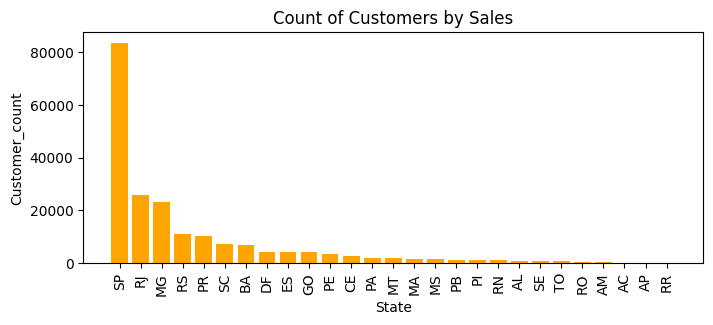

In [76]:
query= """ select customer_state, count(*) as total
from customers
group by customer_state"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns = ['State','Customer_count'])
df= df.sort_values(by="Customer_count", ascending=False)

plt.figure(figsize=(8,3))
plt.bar(df['State'],df['Customer_count'],color="orange")
plt.xticks(rotation = 90)
plt.xlabel('State')
plt.ylabel("Customer_count")
plt.title("Count of Customers by Sales")
plt.show()




# Calculate the number of orders per month in 2018

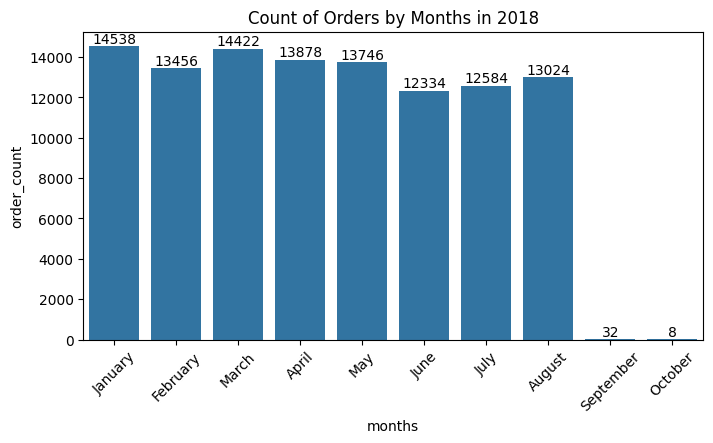

In [75]:
query= """ select monthname(order_purchase_timestamp) months, count(*) as total
from orders 
where year(order_purchase_timestamp) = 2018
group by months"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['months','order_count'])

plt.figure(figsize=(8,4))
o=['January','February','March','April','May','June','July','August','September','October']
ax=sns.barplot(x = df['months'], y = df['order_count'], data=df, order = o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation =45)
plt.title("Count of Orders by Months in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city

In [84]:
query = """with cte as 
(select o.order_id, o.customer_id, count(ot.order_id) as oc
from orders o join order_items ot
on o.order_id = ot.order_id
group by o.order_id, o.customer_id)

select c.customer_city, round(avg(cte.oc),2) average_orders
from customers c join cte
on c.customer_id = cte.customer_id
group by c.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=['customer city','average products/orders'])
df.head(10)


,customer city,average products/orders
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,picarra,8.00
7,morro de sao paulo,8.00
8,teixeira soares,8.00
9,curralinho,8.00


# Calculate the percentage of total revenue contributed by each product category.

In [90]:
query= """ select p.product_category as category,round((sum(py.payment_value)/(select sum(payment_value) from payments ))*100,2) sales_percentage 
from products p join order_items o on p.product_id = o.product_id
join payments py on py.order_id = o.order_id
group by category
order by sales_percentage desc;"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Percentage distribution'])
df

,Category,Percentage distribution
0,bed table bath,21.40
1,HEALTH BEAUTY,20.71
2,computer accessories,19.81
3,Furniture Decoration,17.87
4,Watches present,17.86
...,...,...
69,PC Gamer,0.03
70,House Comfort 2,0.02
71,cds music dvds,0.01
72,Fashion Children's Clothing,0.01


# Identify the correlation between product price and the number of times a product has been purchased.

In [93]:

cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

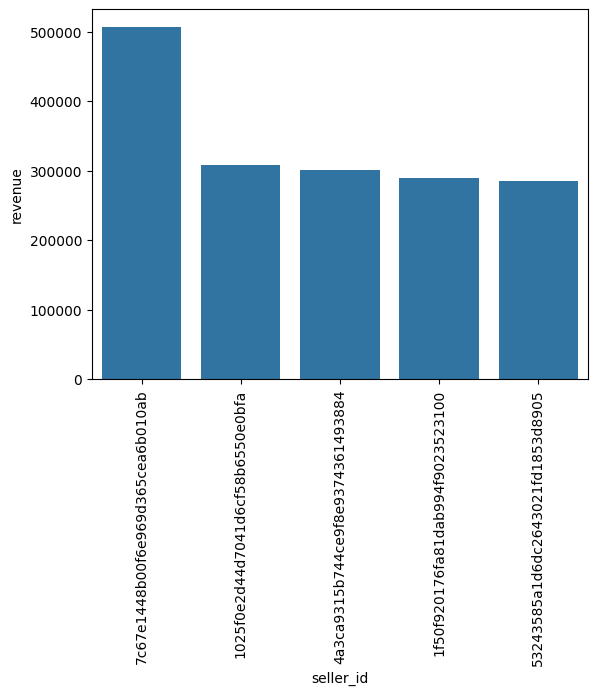

In [96]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [99]:
query = """ 
with cte as(
select o.customer_id,o.order_purchase_timestamp,p.payment_value as payment
from orders o join payments p on o.order_id = p.order_id)

select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
 rows between unbounded preceding and current row) as mov_avg
from cte
 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp","payment", "moving_average"])
df


,customer_id,order_purchase_timestamp,payment,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [108]:
query = """ 

with cte as(
select year(o.order_purchase_timestamp) years,month(o.order_purchase_timestamp) as months,
round(sum( p.payment_value),2) as sales
from orders o join payments p on o.order_id=p.order_id
group by years,months
order by years,months
)
select years,months, sales,sum(sales) over(order by years,months)
from cte
 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "months","sales", "cumulative_sales"])
df

,years,months,sales,cumulative_sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# Calculate the year-over-year growth rate of total sales.

In [117]:

query = """ 
WITH cte AS (
    SELECT YEAR(o.order_purchase_timestamp) AS years,
           ROUND(SUM(p.payment_value), 2) AS sales
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    GROUP BY years
    ORDER BY years
)
SELECT 
    years, 
    sales,
    LAG(sales) OVER (ORDER BY years) AS prev_year_sales,
    ROUND(((sales - LAG(sales) OVER (ORDER BY years)) / LAG(sales) OVER (ORDER BY years)) * 100, 2) AS yoy_growth
FROM cte;
 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "sales","prev_year_sales", "yoy_growth"])
df

,years,sales,prev_year_sales,yoy_growth
0,2016,118724.68,NaN,NaN
1,2017,14499493.46,118724.68,12112.7
2,2018,17399526.10,14499493.46,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [122]:
query = """with a as (select c.customer_id,
min(o.order_purchase_timestamp) first_order
from customers c join orders o
on c.customer_id = o.customer_id
group by c.customer_id),

b as (select a.customer_id, count(distinct o.order_purchase_timestamp) next_order
from a join orders o
on o.customer_id = a.customer_id
and o.order_purchase_timestamp > first_order
and o.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

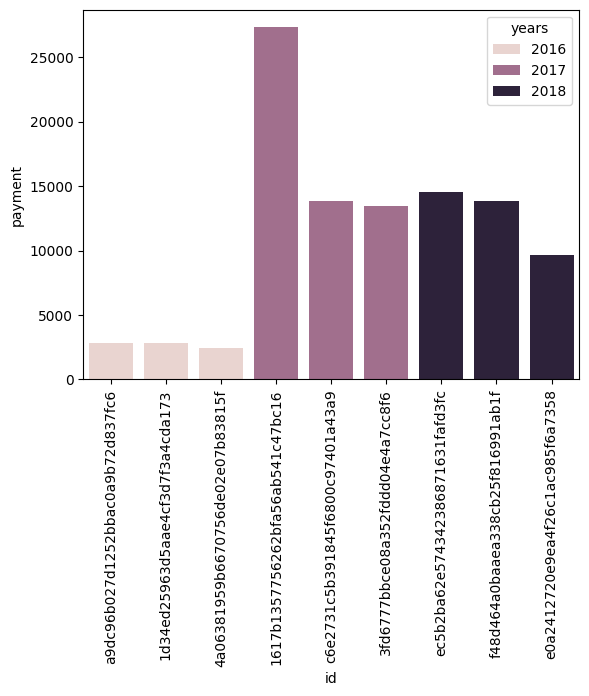

In [123]:
query = """
with cte as
(select year(o.order_purchase_timestamp) years,
o.customer_id,
sum(p.payment_value) payment,
dense_rank() over(partition by year(o.order_purchase_timestamp)
order by sum(p.payment_value) desc) d_rank
from orders o join payments p
on p.order_id = o.order_id
group by year(o.order_purchase_timestamp),
o.customer_id)
select years, customer_id, payment, d_rank
from cte
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()